In [22]:
%matplotlib inline
import pandas as pd
import os

In [2]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final2/quotes'
os.listdir(fpath)

['fiqh_quran_aya_nodes.csv',
 'fiqh_quran_book_nodes.csv',
 'fiqh_quran_links.csv',
 'quran_quotes.csv']

In [38]:
links_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_links.csv'))
nodes_aya_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_aya_nodes.csv'))
nodes_books_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_book_nodes.csv'))
quotes_df = pd.read_csv(os.path.join(fpath, 'quran_quotes.csv'))

In [4]:
links_df.head()

,Source,Target,Weight
0,0179MalikIbnAnas.Muwatta,"(1.0, 4.0)",1
1,0179MalikIbnAnas.Muwatta,"(1.0, 5.0)",1
2,0179MalikIbnAnas.Muwatta,"(2.0, 156.0)",1
3,0179MalikIbnAnas.Muwatta,"(2.0, 178.0)",2
4,0179MalikIbnAnas.Muwatta,"(2.0, 180.0)",1


In [5]:
nodes_aya_df.head()

,id,sura_id,aya_id,sura_name,sura_arabic_name,Type,Label,Group
0,"(65.0, 2.0)",65,2,At-Talaq,الطلاق,aya,At-Talaq 2,aya
1,"(112.0, 1.0)",112,1,Al-Ikhlas,الإخلاص,aya,Al-Ikhlas 1,aya
2,"(65.0, 4.0)",65,4,At-Talaq,الطلاق,aya,At-Talaq 4,aya
3,"(2.0, 196.0)",2,196,Al-Baqarah,البقرة,aya,Al-Baqarah 196,aya
4,"(24.0, 6.0)",24,6,An-Nur,النور,aya,An-Nur 6,aya


In [20]:
merged_df = links_df.merge(nodes_aya_df, left_on='Target', right_on='id')[['Source', 'Weight', 'sura_id', 'aya_id', 'sura_name', 'sura_arabic_name', 'Label']]
merged_df = merged_df.rename({'Label': 'aya_label'}, axis=1)
merged_df = merged_df.merge(nodes_books_df, left_on='Source', right_on='id')
merged_df = merged_df.drop(['Source', 'id', 'Type', 'Group', 'Label'], axis=1)

In [82]:
merged_df.to_csv(os.path.join(fpath, 'quotes_merged.csv'), index=False)

In [83]:
# Nr of quotes per book (including quotes that were not found using alfanous)
#quotes_df.BookURI.value_counts().plot(kind='bar', figsize=(15,8))

Schools: ['حنبلي', 'حنفي', 'شافعي', 'مالكي']


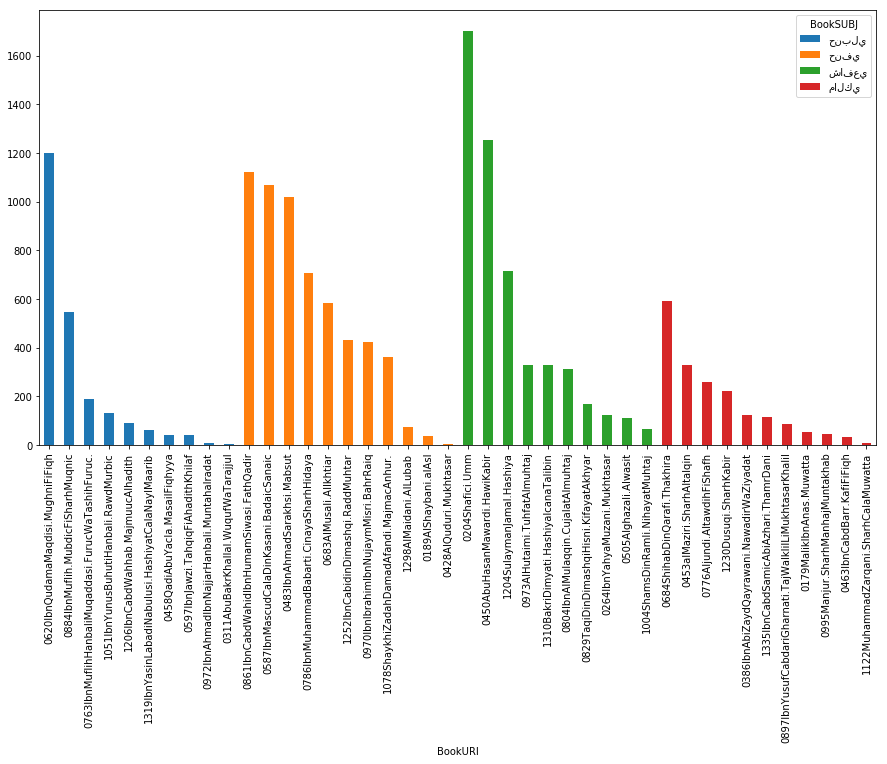

In [62]:
# Nr of quotes per book, sorted per school
count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum().unstack()
print('Schools:', list(count_per_book.columns))
count_per_book.sort_values(list(count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))

In [24]:
# What are the verses cited by most books?
merged_df.aya_label.value_counts()[:20]

An-Nisa' 43       31
An-Nur 33         28
Al-Baqarah 228    28
An-Nisa' 23       28
Al-Ma'idah 6      28
Al-Ikhlas 1       27
Al-Baqarah 184    27
Al-Baqarah 282    27
Al-Baqarah 185    27
Al-Ma'idah 95     27
At-Tawba 103      27
An-Nisa' 11       27
Al-Ma'idah 2      27
Al-Baqarah 196    27
At-Tawba 60       26
Al-Baqarah 222    26
Al-Baqarah 229    26
Al-Mujadila 3     25
Al-Baqarah 178    25
An-Nisa' 25       25
Name: aya_label, dtype: int64

In [36]:
#What are the verses that are most often cited in total?
merged_df.groupby('aya_label')['Weight'].sum().sort_values(ascending=False)[:20]

aya_label
An-Nisa' 23       220
An-Nisa' 43       218
Al-Baqarah 282    211
Al-Baqarah 196    207
Al-Ma'idah 95     199
An-Nisa' 11       197
Al-Ma'idah 6      186
Al-Baqarah 229    163
Al-Baqarah 233    160
Al-Baqarah 228    145
At-Talaq 2        140
Al-Ma'idah 45     122
At-Talaq 1        122
Al-Mujadila 3     122
Al-Baqarah 237    119
An-Nisa' 24       119
Al-Baqarah 222    111
Al-Baqarah 178    110
Al-Ma'idah 89     109
An-Nur 4          108
Name: Weight, dtype: int64

In [37]:
# What are the verses cited by most books, per school?
for school in merged_df.BookSUBJ.unique():
    print(school)
    df_sub = merged_df[merged_df.BookSUBJ==school]
    print('Nr of books: ', df_sub.BookURI.nunique())
    print(df_sub.aya_label.value_counts()[:20])
    print('\n')

مالكي
Nr of books:  11
Al-Ma'idah 5      7
Al-Ma'idah 2      7
Al-Ikhlas 1       7
At-Tawba 103      7
An-Nur 33         7
Al-Ma'idah 45     7
An-Nisa' 43       7
Sad 24            6
Al-Baqarah 238    6
An-Nisa' 11       6
Al-Baqarah 280    6
Al-Ala 1          6
Al-Ma'idah 6      6
Al-Hajj 77        6
Al-Baqarah 185    6
Al-Mujadila 4     5
Al-Baqarah 187    5
An-Nisa' 25       5
Muhammad 33       5
Al-Ma'idah 95     5
Name: aya_label, dtype: int64


شافعي
Nr of books:  10
An-Nisa' 43       10
Al-Baqarah 222    10
Al-Ma'idah 6       9
An-Nisa' 25        9
An-Nisa' 23        9
Al-Baqarah 267     9
At-Talaq 2         9
At-Talaq 6         9
Al-Baqarah 282     9
Al-Baqarah 229     9
At-Tawba 28        9
Al-Baqarah 233     9
Al-Ala 1           8
An-Nur 33          8
Al-Baqarah 185     8
Al-Ma'idah 3       8
An-Nisa' 34        8
Al-Baqarah 228     8
At-Tawba 103       8
Al-Jumua 9         8
Name: aya_label, dtype: int64


حنفي
Nr of books:  11
At-Tawba 60       11
Al-Anfal 41       10
Al-Muj

## Network analysis

In [64]:
import networkx as nx

In [69]:
network = nx.from_pandas_edgelist(links_df, source='Source', target='Target', edge_attr='Weight')

In [70]:
nx.algorithms.is_bipartite(network)

True

In [74]:
# Get projected graphs
nw_books = nx.algorithms.bipartite.overlap_weighted_projected_graph(network, links_df.Source.unique())

In [81]:
nx.to_pandas_edgelist(nw_books).to_csv(os.path.join(fpath, 'links_projected_books.csv'), index=False)

In [77]:
list(nx.to_edgelist(nw_books))[:10]

[('0179MalikIbnAnas.Muwatta',
  '0264IbnYahyaMuzani.Mukhtasar',
  {'weight': 0.08870967741935484}),
 ('0179MalikIbnAnas.Muwatta',
  '0684ShihabDinQarafi.Thakhira',
  {'weight': 0.06628242074927954}),
 ('0179MalikIbnAnas.Muwatta',
  '1004ShamsDinRamli.NihayatMuhtaj',
  {'weight': 0.021505376344086023}),
 ('0179MalikIbnAnas.Muwatta',
  '0884IbnMuflih.MubdicFiSharhMuqnic',
  {'weight': 0.06686046511627906}),
 ('0179MalikIbnAnas.Muwatta',
  '0620IbnQudamaMaqdisi.MughniFiFiqh',
  {'weight': 0.05918367346938776}),
 ('0179MalikIbnAnas.Muwatta',
  '0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFuruc.',
  {'weight': 0.05}),
 ('0179MalikIbnAnas.Muwatta',
  '0829TaqiDinDimashqiHisni.KifayatAkhyar',
  {'weight': 0.11643835616438356}),
 ('0179MalikIbnAnas.Muwatta',
  '0970IbnIbrahimIbnNujaymMisri.BahrRaiq',
  {'weight': 0.07308970099667775}),
 ('0179MalikIbnAnas.Muwatta',
  '1204SulaymanJamal.Hashiya',
  {'weight': 0.061611374407582936}),
 ('0179MalikIbnAnas.Muwatta',
  '0587IbnMascudCalaDinKasani.Bad